In [281]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import imagehash
import glob
from sklearn.metrics import confusion_matrix
import cv2
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image
from pathlib import Path
from skimage.io import imread, imread_collection, imshow, imshow_collection

import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image  # Импортиране на image модула
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [8]:
# Път до главната папка
main_folder = 'data'

# Получаваме имената на подкатегориите (видовете котки)
cat_types = [folder for folder in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder))]

# Печатаме колко различни вида котки има
print(f'There are {len(cat_types)} types of cats: {cat_types}')

There are 7 types of cats: ['african-wildcat', 'blackfoot-cat', 'chinese-mountain-cat', 'domestic-cat', 'european-wildcat', 'jungle-cat', 'sand-cat']


In [9]:
# Разширения на изображенията
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

# Преброяваме изображенията за всеки вид котка
cat_images_count = {}
for cat_type in cat_types:
    cat_folder = os.path.join(main_folder, cat_type)
    images = [f for f in os.listdir(cat_folder) if any(f.endswith(ext) for ext in image_extensions)]
    cat_images_count[cat_type] = len(images)

# Печатаме броя на изображенията за всяка котка
for cat_type, count in cat_images_count.items():
    print(f'{cat_type}: {count} images')

african-wildcat: 91 images
blackfoot-cat: 79 images
chinese-mountain-cat: 42 images
domestic-cat: 64 images
european-wildcat: 85 images
jungle-cat: 86 images
sand-cat: 72 images


In [124]:
image_sizes = []

# Преглеждаме изображенията и получаваме техните размери
for cat_type in cat_types:
    cat_folder = os.path.join(main_folder, cat_type)
    images = [f for f in os.listdir(cat_folder) if any(f.endswith(ext) for ext in image_extensions)]
    for img_file in images:
        img_path = os.path.join(cat_folder, img_file)
        img = Image.open(img_path)
        image_sizes.append(img.size)

# Изчисляваме средната ширина и височина
avg_width = sum(size[0] for size in image_sizes) / len(image_sizes)
avg_height = sum(size[1] for size in image_sizes) / len(image_sizes)
med_width = np.median([size[0] for size in image_sizes])
med_height = np.median([size[1] for size in image_sizes])
min_width = np.min([size[0] for size in image_sizes])
min_height = np.min([size[1] for size in image_sizes])
max_width = np.max([size[0] for size in image_sizes])
max_height = np.max([size[1] for size in image_sizes])

print(f'Average image size: {avg_width:.2f} x {avg_height:.2f}')
print(f'Mediana image size: {med_width:.2f} x {med_height:.2f}')
print(f'Minimum image size: {min_width:.2f} x {min_height:.2f}')
print(f'Maximum image size: {max_width:.2f} x {max_height:.2f}')


Average image size: 406.55 x 310.95
Mediana image size: 275.00 x 194.00
Minimum image size: 150.00 x 124.00
Maximum image size: 4045.00 x 3000.00


In [50]:
images_colection = imread_collection('data/**/*.jpg')
len(images_colection)

519

In [114]:
images_size = np.array([(img.shape[0] * img.shape[1], i) for i, img in enumerate(images_colection)])
images_size = sorted(images_size, key=lambda x: x[0])
all_areas = [image[0] for image in images_size]

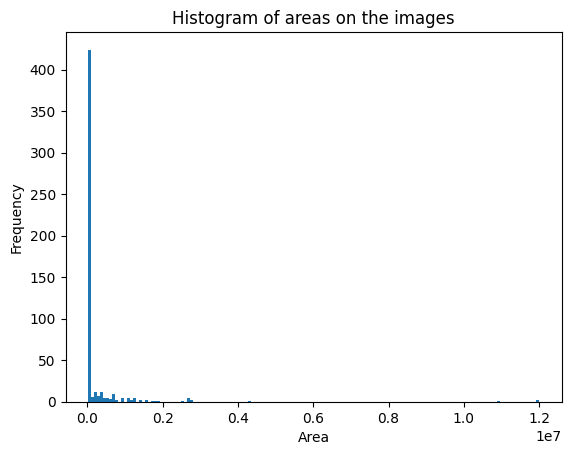

In [115]:
plt.hist(all_areas, bins=150)

plt.title('Histogram of areas on the images')
plt.xlabel('Area')
plt.ylabel('Frequency')

plt.show()

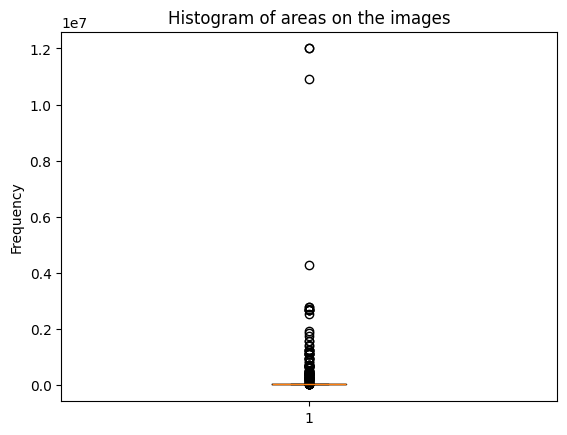

In [116]:
plt.boxplot(all_areas)

plt.title('Histogram of areas on the images')
plt.ylabel('Frequency')

plt.show()

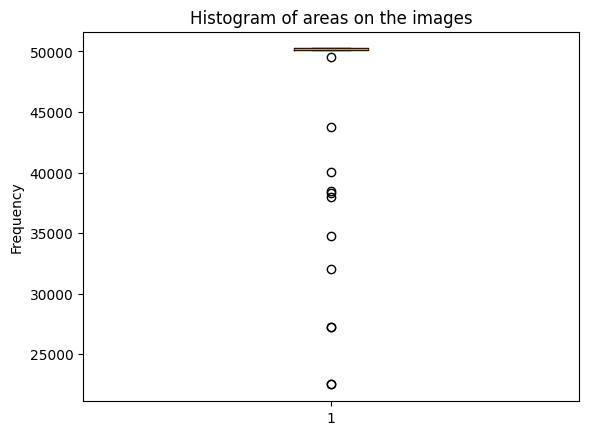

In [119]:
plt.boxplot(all_areas[0: 50])

plt.title('Histogram of areas on the images')
plt.ylabel('Frequency')

plt.show()

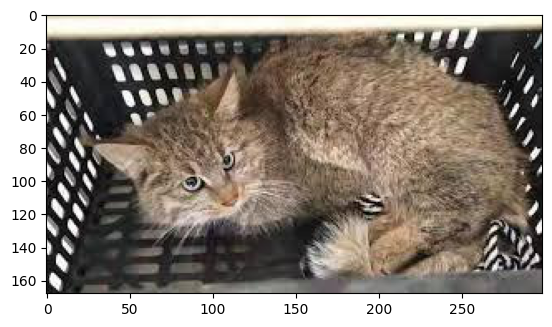

In [134]:
plt.imshow(images_colection[image_sizes[0][1]])

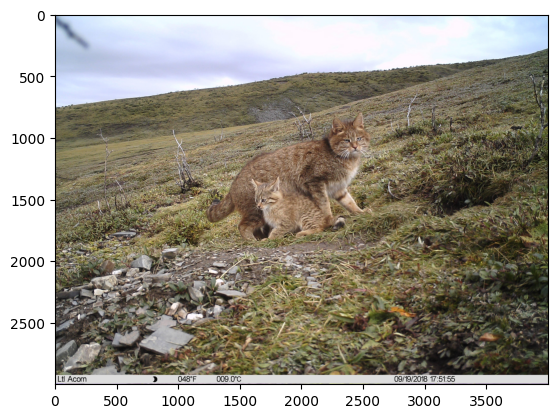

In [135]:
plt.imshow(images_colection[image_sizes[-1][1]])

In [136]:
images_colection[image_sizes[0][1]].shape, images_colection[image_sizes[-1][1]].shape,

((168, 299, 3), (3000, 4000, 3))

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [152]:
def get_file_hash(img):
    pil_img = Image.fromarray(img)
    return imagehash.phash(pil_img)

def find_duplicate_images(images):
    hashes = {}
    dublicates = []
    images_colection_not_dublicates = []

    for i, img in enumerate(images):
        img_hash = get_file_hash(img)

        if img_hash in hashes:
            dublicates.append((hashes[img_hash], i))
        else:
            hashes[img_hash] = i
            images_colection_not_dublicates.append(img)

    return images_colection_not_dublicates, dublicates

images_colection_not_dublicates, dublicates = find_duplicate_images(images_colection)

In [153]:
len(images_colection_not_dublicates), len(dublicates)

(465, 54)

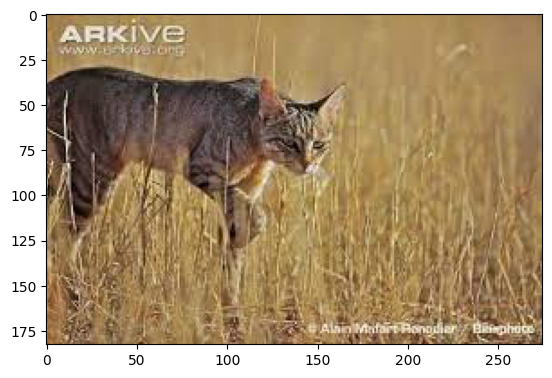

In [149]:
plt.imshow(images_colection[26])

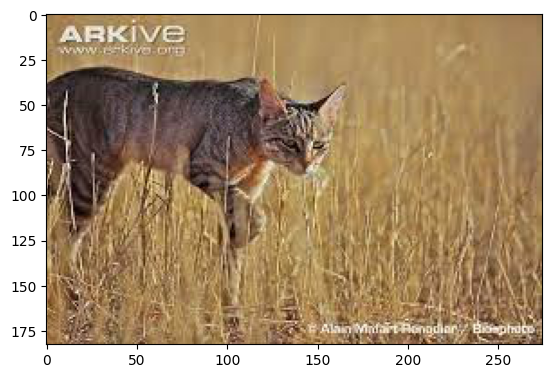

In [148]:

plt.imshow(images_colection[31])

### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [156]:
# Load the pre-trained ResNet50 model
model = ResNet50(weights="imagenet")

# Get the total number of layers
num_layers = len(model.layers)

# Get the total number of parameters
num_params = model.count_params()

print(f"Total number of layers: {num_layers}")
print(f"Total number of parameters: {num_params:,}")

Total number of layers: 177
Total number of parameters: 25,636,712


In [161]:
first_layer = model.layers[2]
weights, biases = first_layer.get_weights()

print("Weights shape:", weights.shape)
print("Biases shape:", biases.shape)

Weights shape: (7, 7, 3, 64)
Biases shape: (64,)


In [162]:
for i, layer in enumerate(model.layers[:5]):
    print(i, layer.name, type(layer))

0 input_layer <class 'keras.src.layers.core.input_layer.InputLayer'>
1 conv1_pad <class 'keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D'>
2 conv1_conv <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
3 conv1_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
4 conv1_relu <class 'keras.src.layers.activations.activation.Activation'>


### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [188]:
resize_images_image_format = np.array([np.array(Image.fromarray(img).resize((224, 224)), dtype=np.float32) / 255 for img in images_colection_not_dublicates])
resize_images_np_format = np.array([np.resize(img, (224, 224, img.shape[2])) for img in images_colection_not_dublicates]).astype(float)

In [198]:
prediction_np_format = model.predict(resize_images_np_format)

15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


In [189]:
resize_images_image_format[0].dtype

dtype('float32')

In [190]:
prediction_image_format = model.predict(resize_images_image_format)

15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step


### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [241]:
# Стъпка 1: Зареждаме предварително обучен ResNet50 модел без последния слой
base_model = ResNet50(weights='imagenet', include_top=False)  # Без последния слой

# Стъпка 2: Добавяме глобален пул слой за преобразуване на изхода в 1D вектор
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Преобразуваме изхода в едномерно

# Стъпка 3: Добавяме новия слой за класификация с 7 класа
x = Dense(7, activation='softmax')(x)

# Стъпка 4: Създаваме новия модел
model = Model(inputs=base_model.input, outputs=x)

# Стъпка 5: Компилираме модела (също така може да добавите оптимизатор и метрики)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Проверяваме структурата на модела
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)   │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, None, None, 3)     │               0 │ input_layer_13[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, None, None, 64)    │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, None, None, 64)    │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, None, None, 64)    │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, None, None, 64)    │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, None, None, 64)    │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, None, None, 64)    │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, None, None, 64)    │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [243]:

# Път към папката с данни
image_dir = 'data/'

# Зареждаме пътищата на изображенията и класовете
def load_image_paths_and_labels(image_dir):
    image_paths = []
    image_labels = []
    class_names = sorted(os.listdir(image_dir))  # Имената на класовете (директориите)

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(image_dir, class_name)
        if os.path.isdir(class_path):  # Проверяваме дали е директория (клас)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                # Игнорираме файлове, които започват с "."
                if img_name.startswith("."):
                    continue
                
                image_paths.append(img_path)
                image_labels.append(class_idx)  # Добавяме етикет за съответния клас (индекс)
    
    return image_paths, image_labels, class_names

image_paths, image_labels, class_names = load_image_paths_and_labels(image_dir)

def load_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Преоразмеряване на изображението
    img_array = image.img_to_array(img)  # Преобразуваме изображението в масив
    img_array = np.expand_dims(img_array, axis=0)  # Добавяме нова ос за партида
    img_array /= 255.0  # Нормализираме изображението
    return img_array

def predict_labels(model, image_paths, batch_size):
    predicted_labels = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch = np.zeros((len(batch_paths), 224, 224, 3))  # Размер на партидата

        # Зареждаме и обработваме изображенията
        for j, img_path in enumerate(batch_paths):
            batch[j] = load_image(img_path)

        # Получаваме предсказания за партидата
        batch_predictions = model.predict(batch)
        
        # Извеждаме етикетите с най-голяма вероятност
        batch_predicted_labels = np.argmax(batch_predictions, axis=1)
        predicted_labels.extend(batch_predicted_labels)
    
    return predicted_labels    

def show_results(predicted_labels, image_paths, class_names):
    """Показва резултатите за всяко изображение."""
    for i, label in enumerate(predicted_labels):
        if label < len(class_names):  # Проверяваме дали индексът е валиден
            print(f"Image {image_paths[i]} is predicted as class {class_names[label]}")
        else:
            print(f"Image {image_paths[i]} has an invalid prediction label: {label}")

# Броят на изображенията в партида (може да бъде променен)
batch_size = 32

# Зареждаме пътищата на изображенията
image_paths, image_labels, class_names = load_image_paths_and_labels(image_dir)

# Предсказваме етикетите
predicted_labels = predict_labels(model, image_paths, batch_size)

# Показваме резултатите
show_results(predicted_labels, image_paths, class_names)



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Image data/african-wildcat\af (1).jpg is predicted as class chinese-mountain-cat
Image data/african-wildcat\af (10).jpg is predicted as class chinese-mountain-cat
Image data/african-wildcat\af (11).jpg is predicted as class chinese-mountain-cat
Image data/african-wildcat\af (12).jpg is predicted as class chinese-mountain-cat
Image data/african-wildcat\af (13).jpg is predicted as class 

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [246]:
class_names = ["african-wildcat", "blackfoot-cat", "chinese-mountain-cat", "domestic-cat", "european-wildcat", "jungle-cat", "sand-cat"]
class_to_index = {class_name: index for index, class_name in enumerate(class_names)}

In [248]:
def get_true_label(image_path, class_to_index):
    # Извлича името на последната папка, която съдържа изображението
    class_name = os.path.basename(os.path.dirname(image_path))
    return class_to_index[class_name]

# Пример: Получаване на истинските етикети за всички изображения
true_labels = [get_true_label(image_path, class_to_index) for image_path in image_paths]

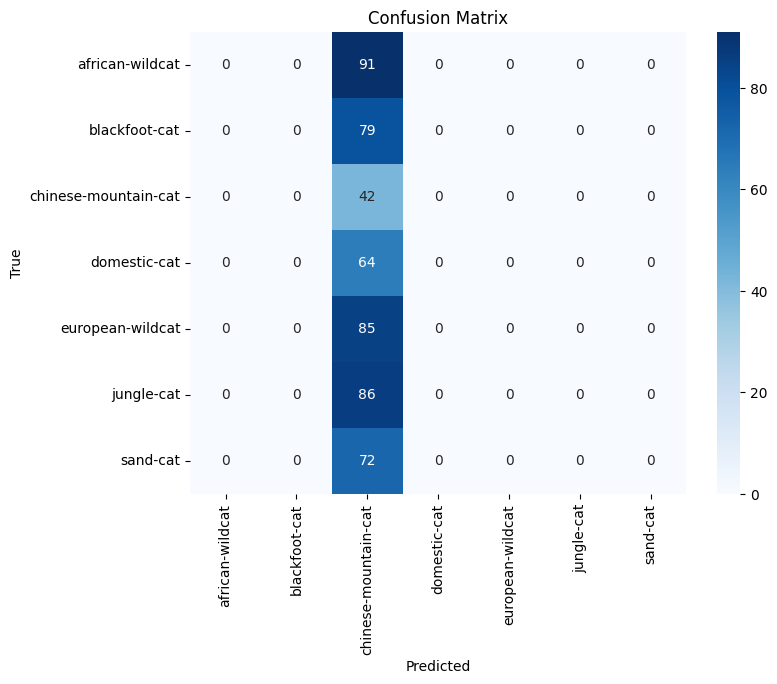

In [253]:

# Генерираме confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Визуализираме confusion matrix с heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [266]:
gray_images_list = []

for img in images_colection:
    # Convert image to NumPy array if not already
    img = np.array(img, dtype=np.float32)

    # Ensure all images are resized to (224, 224)
    img_resized = cv2.resize(img, (224, 224))

    # Convert RGB to grayscale
    if len(img_resized.shape) == 3 and img_resized.shape[-1] == 3:
        img_gray = np.dot(img_resized[..., :3], [0.2989, 0.5870, 0.1140])  # Grayscale conversion
    else:
        img_gray = img_resized  # Already grayscale

    # Ensure the shape is (224, 224, 1)
    img_gray = img_gray.reshape(224, 224, 1)

    gray_images_list.append(img_gray)

# Convert list to NumPy array
gray_images_np_format = np.array(gray_images_list, dtype=np.float32)

In [274]:
predicted_labels = []
gray_images_rgb = np.repeat(gray_images_np_format, 3, axis=-1)  # Convert to RGB

# Debugging: Check shapes
print(f"Gray Image Shape Before: {gray_images_np_format.shape}")  # Should be (N, 224, 224, 1)
print(f"Gray Image Shape After Conversion: {gray_images_rgb.shape}")  # Should be (N, 224, 224, 3)

# Make predictions
batch_predictions = model.predict(gray_images_rgb)

# Ensure predictions are probabilities per class
print("Predictions Shape:", batch_predictions.shape)  # Should be (N, num_classes)

# Extract class with highest probability
batch_predicted_labels = np.argmax(batch_predictions, axis=1)

# Extend the list properly
predicted_labels.extend(batch_predicted_labels.tolist())

# Debugging: Print a few predictions
print("Sample Predicted Labels:", predicted_labels[:10])

Gray Image Shape Before: (519, 224, 224, 1)
Gray Image Shape After Conversion: (519, 224, 224, 3)
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Predictions Shape: (519, 7)
Sample Predicted Labels: [6, 1, 4, 6, 6, 6, 6, 6, 1, 6]


In [275]:
len(predicted_labels)

519

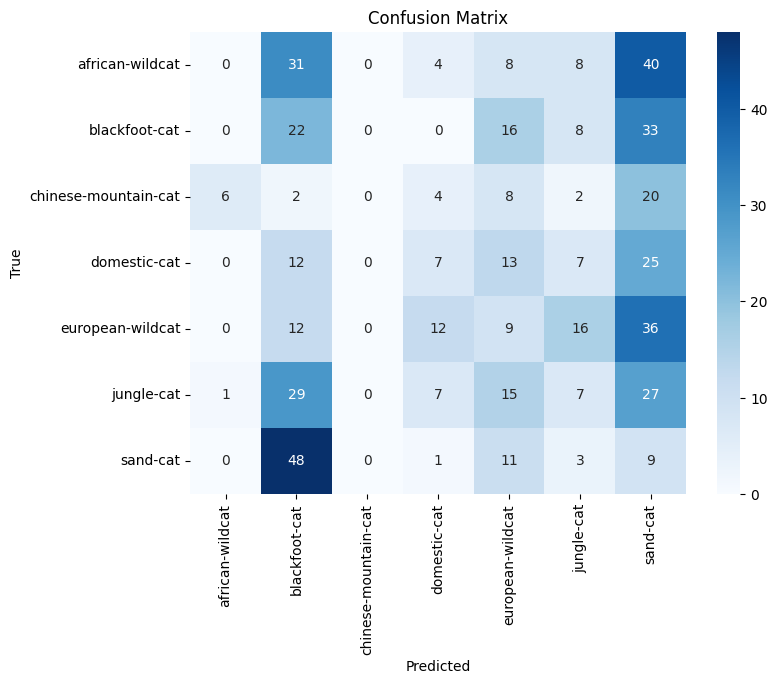

In [276]:
images_colection_not_dublicates, dublicates = find_duplicate_images(images_colection)

cm = confusion_matrix(true_labels, predicted_labels)

# Визуализираме confusion matrix с heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

In [278]:
# Зареждаме предварително обучен ResNet50 модел без последния слой
base_model = ResNet50(weights='imagenet', include_top=False)  # Без последния слой

# Добавяме глобален пул слой за преобразуване на изхода в 1D вектор
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Преобразуваме изхода в едномерно представяне (features)

# Стъпка 3: Добавяме новия слой за класификация с 7 класа
x = Dense(7, activation='softmax')(x)

# Създаваме нов модел, който извежда характеристиките
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Проверяваме структурата на модела за извличане на характеристики
feature_extractor.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)   │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, None, None, 3)     │               0 │ input_layer_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, None, None, 64)    │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, None, None, 64)    │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, None, None, 64)    │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, None, None, 64)    │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, None, None, 64)    │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, None, None, 64)    │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, None, None, 64)    │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, None, None, 64)    │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, None, None, 64)    │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, None, None, 256)   │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [279]:
def extract_features(images, feature_extractor):
    # Подаваме изображенията през модела за извличане на характеристики
    features = feature_extractor.predict(images)
    
    return features

# Извличаме характеристиките
features = extract_features(resize_images_np_format, feature_extractor)

# Проверката на формата на характеристиките
features.shape

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step
(465, 7)


In [280]:
features[0]

array([0.5974957 , 0.02759637, 0.17318848, 0.08189619, 0.02422968,
       0.07948088, 0.01611275], dtype=float32)

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

In [282]:
# Assuming `features` is a 2D array of shape (num_images, 7)
# and that each row is a feature vector for an image.

# 1. Cosine Similarity between all image feature vectors
cosine_sim = cosine_similarity(features)  # Returns a matrix of size (num_images, num_images)

# 2. Mean Squared Error (MSE) between all image feature vectors
def mean_squared_error(x, y):
    return np.mean((x - y) ** 2)

# Compute MSE pairwise (for each pair of image feature vectors)
mse_sim = np.array([[mean_squared_error(features[i], features[j]) for j in range(features.shape[0])] for i in range(features.shape[0])])

# To find the most similar images, you can sort the similarity matrices or MSE
# For cosine similarity: higher values indicate more similarity
# For MSE: lower values indicate more similarity

# Example: finding the most similar image to the first image
most_similar_index_cosine = np.argmax(cosine_sim[0, 1:]) + 1  # Exclude the comparison with itself
most_similar_index_mse = np.argmin(mse_sim[0, 1:]) + 1  # Exclude the comparison with itself

print(f"Most similar image to image 0 based on cosine similarity: {most_similar_index_cosine}")
print(f"Most similar image to image 0 based on MSE: {most_similar_index_mse}")

Most similar image to image 0 based on cosine similarity: 38
Most similar image to image 0 based on MSE: 38


### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.